# Load Data

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# Use the file upload widget
from google.colab import files
files.upload()  # Upload your kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beyzabal0","key":"91cff5f1980f29e22e2d53dcc5a1d50b"}'}

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!cp kaggle.json /root/.kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

 99% 3.12G/3.14G [00:24<00:00, 112MB/s] 
100% 3.14G/3.14G [00:24<00:00, 138MB/s]


In [ ]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [ ]:
!unzip home-credit-credit-risk-model-stability.zip

Archive:  home-credit-credit-risk-model-stability.zip
  inflating: csv_files/test/test_applprev_1_0.csv  
  inflating: csv_files/test/test_applprev_1_1.csv  
  inflating: csv_files/test/test_applprev_1_2.csv  
  inflating: csv_files/test/test_applprev_2.csv  
  inflating: csv_files/test/test_base.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_3.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_4.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_10.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_11.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_3.csv  
  inflating: csv_files/test/test_credit_burea

In [ ]:
dataPath = "/content/"

In [ ]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# Join Tables & Feature Engineering

In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [ ]:
data = data.to_pandas()
data['date_decision'] = pd.to_datetime(data['date_decision'])
print(f"Date range: {data['date_decision'].min()} to {data['date_decision'].max()}")
print(f"Week range: {data['WEEK_NUM'].min()} to {data['WEEK_NUM'].max()}")

Date range: 2019-01-01 00:00:00 to 2020-10-05 00:00:00
Week range: 0 to 91


In [ ]:
# Pre-COVID training, COVID validation/testing
covid_start = pd.Timestamp('2020-03-01')
mid_covid = pd.Timestamp('2020-07-01')

# Split data based on these dates
train_data = data[data['date_decision'] < covid_start]             # Pre-COVID (Jan 2019-Feb 2020)
valid_data = data[(data['date_decision'] >= covid_start) &
                  (data['date_decision'] < mid_covid)]            # Early COVID (Mar 2020-Jun 2020)
test_data = data[data['date_decision'] >= mid_covid]              # Later COVID (Jul 2020-Oct 2020)

# Print split information
print(f"Training (pre-COVID): {len(train_data)} samples ({train_data['date_decision'].min()} to {train_data['date_decision'].max()})")
print(f"Validation (early COVID): {len(valid_data)} samples ({valid_data['date_decision'].min()} to {valid_data['date_decision'].max()})")
print(f"Test (later COVID): {len(test_data)} samples ({test_data['date_decision'].min()} to {test_data['date_decision'].max()})")

Training (pre-COVID): 1232695 samples (2019-01-01 00:00:00 to 2020-02-29 00:00:00)
Validation (early COVID): 143724 samples (2020-03-01 00:00:00 to 2020-06-30 00:00:00)
Test (later COVID): 150240 samples (2020-07-01 00:00:00 to 2020-10-05 00:00:00)


In [ ]:
cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
print(cols_pred)

base_train = train_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_train = train_data["target"]
X_train = train_data[cols_pred]

base_valid = valid_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_valid = valid_data["target"]
X_valid = valid_data[cols_pred]

base_test = test_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_test = test_data["target"]
X_test = test_data[cols_pred]

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

/tmp/ipython-input-3609418592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("string").astype('category')
/tmp/ipython-input-3609418592.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
/tmp/ipython-input-3609418592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (1232695, 48)
Valid: (143724, 48)
Test: (150240, 48)


In [ ]:
print(f"Train: {y_train.shape}")
print(f"Valid: {y_valid.shape}")
print(f"Test: {y_test.shape}")

Train: (1232695,)
Valid: (143724,)
Test: (150240,)


# Reduce Memory Usage

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [ ]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
X_test = reduce_mem_usage(X_test)

/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1153062793.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)
/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1153062793.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [ ]:
X_train_new = pd.concat([X_train, X_valid], axis=0)
X_train_new=convert_strings(X_train_new)
X_train_new = reduce_mem_usage(X_train_new)
y_train_new = pd.concat([y_train, y_valid], axis=0)
base_train_new = pd.concat([base_train, base_valid], axis=0)

/tmp/ipython-input-3156404708.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train_new = pd.concat([X_train, X_valid], axis=0)
/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1153062793.py:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(n

# Light GBM

In [ ]:
# Original parameters
params1 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 6,
    "num_leaves": 63,
    "min_data_in_leaf": 20,
    "learning_rate": 0.01,
    "n_estimators": 2038,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "min_gain_to_split": 0.1,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 3,
    "verbose": -1
}


In [ ]:
params2 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 982,
    "num_leaves": 64,
    "max_depth": 5,
    "min_data_in_leaf": 300,
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    "min_gain_to_split": 0.5,
    "verbose": -1,
}


In [ ]:
params3 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 7,
    "min_data_in_leaf": 500,
    "learning_rate": 0.2,
    "n_estimators": 943,
    "lambda_l1": 10.0,
    "feature_fraction": 0.3,
    "verbose": -1
}

In [ ]:
params4 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 4,
    "num_leaves": 16,
    "min_data_in_leaf": 10000,
    "learning_rate": 0.1,
    "n_estimators": 2000,
    "lambda_l1": 10.0,
    "lambda_l2": 1.0,
    "feature_fraction": 0.4,
    "verbose": -1
}

In [ ]:
from lightgbm import LGBMClassifier

lgbm1 = LGBMClassifier(**params1)
lgbm2 = LGBMClassifier(**params2)
lgbm3 = LGBMClassifier(**params3)
lgbm4 = LGBMClassifier(**params4)

In [ ]:
import gc
gc.collect()
del data, X_train, X_valid

In [ ]:
lgbm1.fit(
    X_train_new, y_train_new,
    callbacks=[
        lgb.callback.log_evaluation(period=100)
    ]
)
gc.collect()
y_pred1 = lgbm1.predict_proba(X_test)[:, 1]
gc.collect()

4

In [ ]:
lgbm2.fit(
    X_train_new, y_train_new,
    callbacks=[
        lgb.callback.log_evaluation(period=100)
    ]
)
gc.collect()
y_pred2 = lgbm2.predict_proba(X_test)[:, 1]
gc.collect()

4

In [ ]:
lgbm3.fit(
    X_train_new, y_train_new,
    callbacks=[
        lgb.callback.log_evaluation(period=100)
    ]
)
gc.collect()
y_pred3 = lgbm3.predict_proba(X_test)[:, 1]
gc.collect()

4

In [ ]:
lgbm4.fit(
    X_train_new, y_train_new,
    callbacks=[
        lgb.callback.log_evaluation(period=100)
    ]
)
gc.collect()
y_pred4 = lgbm4.predict_proba(X_test)[:, 1]
gc.collect()

4

In [ ]:
for base, X in [(base_train_new, X_train_new), (base_test, X_test)]:
    # Get probability predictions from each model

    y_pred1 = lgbm1.predict_proba(X)[:, 1]
    y_pred2 = lgbm2.predict_proba(X)[:, 1]
    y_pred3 = lgbm3.predict_proba(X)[:, 1]
    y_pred4 = lgbm4.predict_proba(X)[:, 1]


    # Average the predictions (simple ensemble)
    y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4) / 4

    # Convert to binary predictions
    train_prevalence = y_train_new.mean()
    threshold = np.percentile(y_pred, 100 * (1 - train_prevalence))
    y_pred_labels = (y_pred > threshold).astype(int)

    base["score"] = y_pred
    base["pred"] = y_pred_labels

/tmp/ipython-input-2477590332.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
/tmp/ipython-input-2477590332.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred_labels


# Evaluation

In [ ]:
print(f'The AUC score on the train set is: {roc_auc_score(base_train_new["target"], base_train_new["score"])}')
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set is: 0.7926968558395198
The AUC score on the test set is: 0.7851029929183919


In [ ]:
print(f'The classification error on the train set is: {1- accuracy_score(base_train_new["target"], base_train_new["pred"])}')
print(f'The classification error on the test set is: {1-accuracy_score(base_test["target"], base_test["pred"])}')

The classification error on the train set is: 0.05127217802137285
The classification error on the test set is: 0.04400958466453675


In [ ]:
print(f'The brier score on the train set is: {brier_score_loss(base_train_new["target"], base_train_new["score"])}')
print(f'The brier score on the test set is: {brier_score_loss(base_test["target"], base_test["score"])}')

The brier score on the train set is: 0.029581698790318574
The brier score on the test set is: 0.019771843485040935


In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return gini_in_time, avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [ ]:
gini_in_time_train, stability_score_train = gini_stability(base_train_new)
gini_in_time_test, stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.5654108649350914
The stability score on the test set is: 0.5472901867167136


In [ ]:
# Combine all three datasets into one
all_scores_combined = pd.concat(
    [base_train_new, base_test],
    axis=0,
    ignore_index=False
)

In [ ]:
gini_in_time, stability_score = gini_stability(all_scores_combined)

print(f'The stability score is: {stability_score}')

The stability score is: 0.5585866218509441


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculate_weekly_cumulative_stability(df, w_fallingrate=88.0, w_resstd=-0.5):

    unique_weeks = sorted(df['WEEK_NUM'].unique())
    results = []

    for i in range(1, len(unique_weeks)):
        end_week = unique_weeks[i]

        cumulative_week_nums = unique_weeks[:i+1]

        cumulative_data = df[df['WEEK_NUM'].isin(cumulative_week_nums)].copy()

        gini_values, stability_score = gini_stability(cumulative_data, w_fallingrate, w_resstd)

        results.append({
            'end_week': end_week,
            'cumulative_weeks': cumulative_week_nums.copy(),
            'stability_score': stability_score,
            'gini_values': gini_values,
            'avg_gini': np.mean(gini_values),
            'week_count': len(gini_values)
        })

    return pd.DataFrame(results)

In [ ]:
stability_results = calculate_weekly_cumulative_stability(base_test)


print(stability_results[['end_week', 'stability_score', 'avg_gini']])

    end_week  stability_score  avg_gini
0         79         0.088858  0.609695
1         80        -1.909773  0.591771
2         81        -2.912147  0.568332
3         82        -2.766439  0.550448
4         83        -0.968894  0.555596
5         84        -0.513891  0.553966
6         85        -0.009111  0.556588
7         86         0.286743  0.559049
8         87         0.315693  0.558220
9         88         0.541190  0.562001
10        89         0.545009  0.565023
11        90         0.544255  0.563725
12        91         0.547290  0.566474


In [ ]:
feature_cols = X_train_new.columns

combined_df_train = pd.concat([base_train_new, pd.DataFrame(X_train_new, columns=feature_cols)], axis=1)
combined_df_test = pd.concat([base_test, pd.DataFrame(X_test, columns=feature_cols)], axis=1)

In [ ]:
combined_df_train['dataset'] = 'train'
combined_df_test['dataset'] = 'test'

# Combine all three datasets into one
full_combined_df = pd.concat(
    [combined_df_train, combined_df_test],
    axis=0,
    ignore_index=False
)

/tmp/ipython-input-2305255525.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_combined_df = pd.concat(


In [ ]:
def plot_stability_decomposition(model_name, gini_values, weeks=None):

    if weeks is None:
        weeks = np.arange(len(gini_values))

    # Ensure inputs are numpy arrays
    weeks = np.array(weeks)
    gini_values = np.array(gini_values)

    # Calculate trend line
    x_indices = np.arange(len(gini_values))
    y = np.array(gini_values)
    a, b = np.polyfit(x_indices, y, 1)
    y_trend = a * x_indices + b
    residuals = y - y_trend

    # Calculate stability components
    avg_gini = np.mean(gini_values)
    w_fallingrate = 88.0
    w_resstd = -0.5
    trend_component = w_fallingrate * min(0, a)
    res_std = np.std(residuals)
    residual_component = w_resstd * res_std
    final_score = avg_gini + trend_component + residual_component

    # Calculate percentage contributions of each component
    # Use absolute values for percentage calculation to handle negative values correctly
    total_absolute_contribution = abs(avg_gini) + abs(trend_component) + abs(residual_component)

    if total_absolute_contribution > 0:
        avg_gini_pct = (abs(avg_gini) / total_absolute_contribution) * 100
        trend_component_pct = (abs(trend_component) / total_absolute_contribution) * 100
        residual_component_pct = (abs(residual_component) / total_absolute_contribution) * 100
    else:
        avg_gini_pct = trend_component_pct = residual_component_pct = 0

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12),
                                        gridspec_kw={'height_ratios': [3, 1, 1.5]})

    # Plot 1: Gini values and trend
    # Use scatter for individual points and line for connecting them
    ax1.scatter(weeks, gini_values, color='blue', s=30, zorder=3)
    ax1.plot(weeks, gini_values, '-', color='blue', alpha=0.6, label='Weekly Gini')

    # Add trend line and average
    ax1.plot(weeks, y_trend, 'r--', linewidth=2, label=f'Trend (slope={a:.4f})')
    ax1.axhline(y=avg_gini, color='g', linestyle=':', linewidth=2, label=f'Avg Gini={avg_gini:.4f}')

    # Style the plot
    ax1.set_ylabel('Gini Coefficient', fontsize=12)
    ax1.set_title(f'Model: {model_name} - Stability Score: {final_score:.4f}', fontsize=14)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Set y-axis limits with some padding
    y_min = min(gini_values) - 0.03
    y_max = max(gini_values) + 0.03
    ax1.set_ylim(y_min, y_max)

    # Plot 2: Residuals - make sure each point is visible
    ax2.plot(weeks, residuals, color='orange', alpha=0.7, marker='o', linewidth=2)
    ax2.axhline(y=0, color='k', linestyle='-')
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title(f'Model: {model_name} - Residual StdDev: {res_std:.4f} (Impact: {residual_component:.4f})', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set symmetric y limits for residuals
    res_limit = max(abs(min(residuals)), abs(max(residuals))) * 1.1
    ax2.set_ylim(-res_limit, res_limit)
    ax2.set_xlabel('Week', fontsize=12)

    # Plot 3: Component Breakdown - Horizontal bar chart with percentages
    components = [avg_gini, trend_component, residual_component]
    percentages = [avg_gini_pct, trend_component_pct, residual_component_pct]

    # Create component labels with percentages
    labels = [
        f'Avg Gini [{avg_gini_pct:.1f}%]',
        f'Trend Component [{trend_component_pct:.1f}%]',
        f'Residual Component [{residual_component_pct:.1f}%]'
    ]

    colors = ['green', 'blue' if trend_component > 0 else 'red', 'orange']

    y_pos = np.arange(len(components))

    # Create horizontal bar chart - with normal positioning for labels
    bars = ax3.barh(y_pos, components, color=colors, height=0.6)
    ax3.axvline(x=0, color='k', linestyle='-')
    ax3.set_ylabel('Component', fontsize=12)
    ax3.set_xlabel('Score Contribution', fontsize=12)
    ax3.set_title(f'Model: {model_name} - Component Breakdown (Final Score: {final_score:.4f})', fontsize=12)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(labels, fontsize=11)
    ax3.grid(True, axis='x', alpha=0.3)

    # Keep default padding for y-ticks (reset to normal)
    ax3.tick_params(axis='y', pad=5)  # Normal padding

    # Add final score line
    ax3.axvline(x=final_score, color='blue', linestyle='--', linewidth=2)
    ax3.text(final_score, len(components), f'Final: {final_score:.4f}',
             color='blue', fontweight='bold', va='bottom', ha='center')

    # Add value labels on component bars
    for i, v in enumerate(components):
        # Position the text inside or outside the bar based on value
        if abs(v) > 0.05:
            ax3.text(v/2 if v > 0 else v/2, i, f'{v:.4f}',
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        else:
            # For very small values, position text at end of bar
            ax3.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.4f}',
                    ha='left' if v > 0 else 'right', va='center',
                    color='black', fontweight='bold', fontsize=10)

    # Remove the connection between subplots (no shared x-axis)
    plt.subplots_adjust(hspace=0.3)

    # Add specific x-ticks for weeks with reasonable intervals
    week_step = max(1, len(weeks) // 10)  # Show about 10 ticks
    week_ticks = weeks[::week_step]
    ax1.set_xticks(week_ticks)
    ax1.set_xticklabels([str(int(w)) for w in week_ticks])

    ax2.set_xticks(week_ticks)
    ax2.set_xticklabels([str(int(w)) for w in week_ticks])

    # Set limits for component chart
    max_component = max(abs(min(components)), abs(max(components)), abs(final_score))
    ax3.set_xlim(-max_component * 0.15, max_component * 1.15)  # Add some padding

    plt.tight_layout()
    return fig, residuals

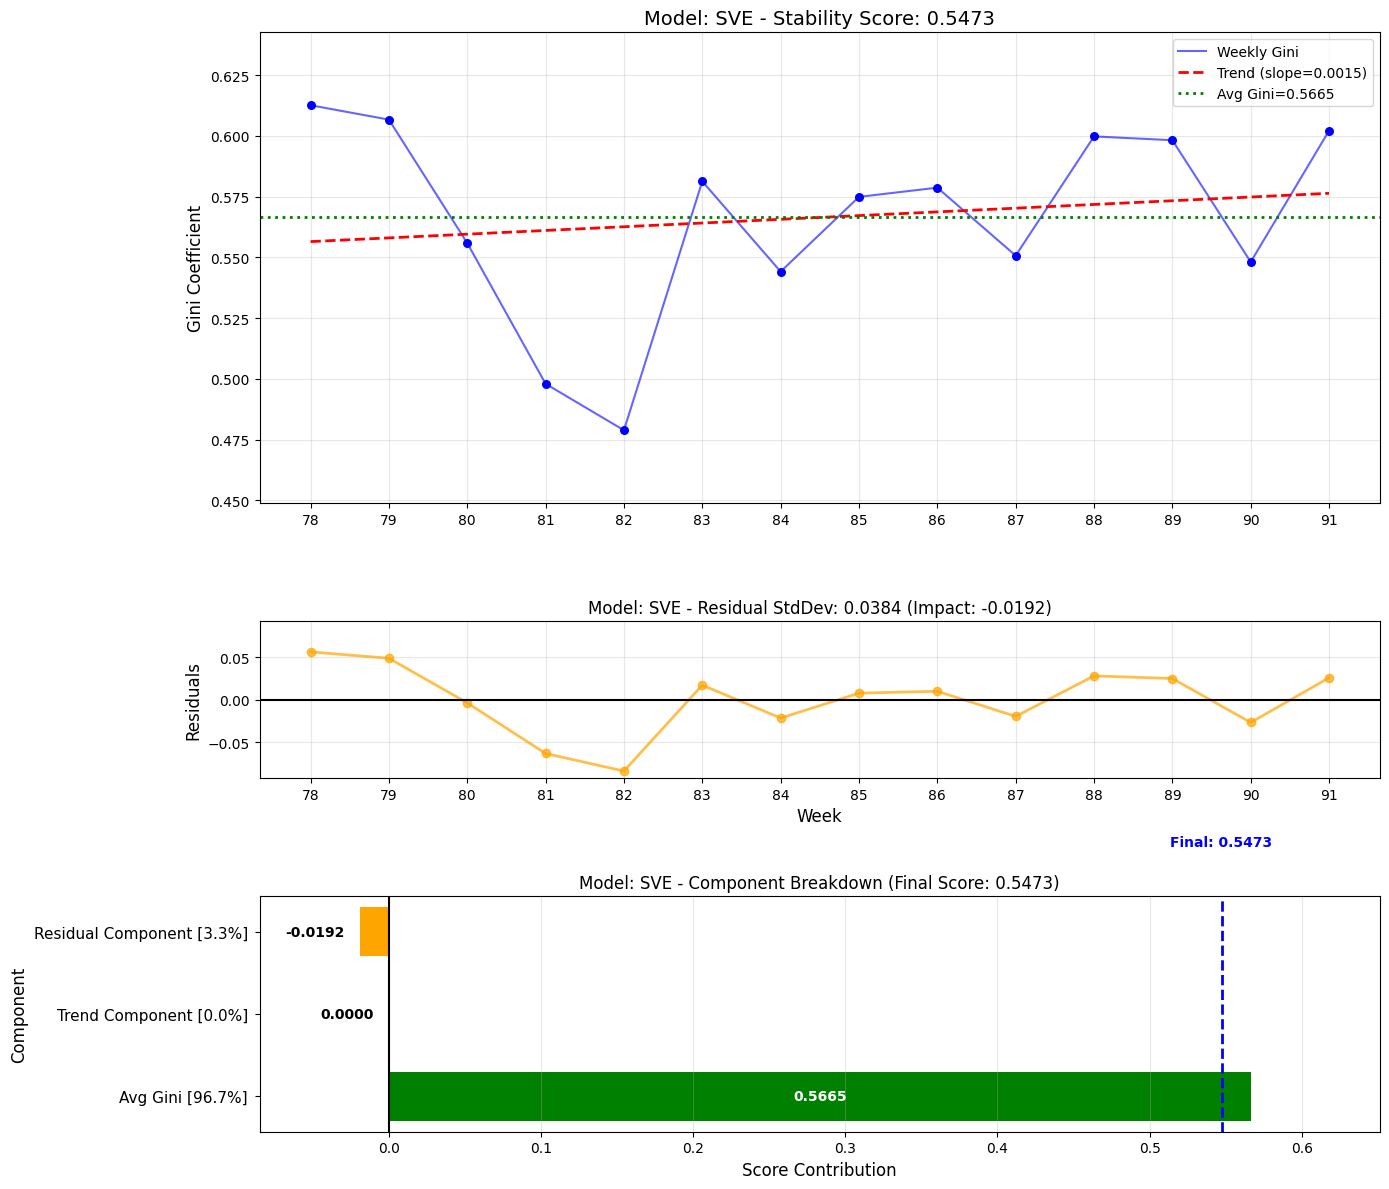

In [ ]:
weeks = range(78,92)
fig, test_residuals = plot_stability_decomposition("SVE", gini_in_time_test, weeks)
plt.savefig('SVE_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def plot_cumulative_min_slope(base):
    # Get Gini coefficients by week
    gini_by_week = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    weeks = sorted(base["WEEK_NUM"].unique())
    min_slopes = []

    # Calculate cumulative min(0, slope) for each week
    for i in range(1, len(weeks)):
        x = np.arange(i + 1)
        y = gini_by_week[:i + 1]
        a, b = np.polyfit(x, y, 1)
        min_slopes.append(min(0, a))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(weeks[1:], min_slopes, 'o-')
    plt.xlabel('Week')
    plt.ylabel('min(0, a)')
    plt.title('min(0, a) by Week - SVE')
    plt.grid(True)
    plt.show()

    return min_slopes


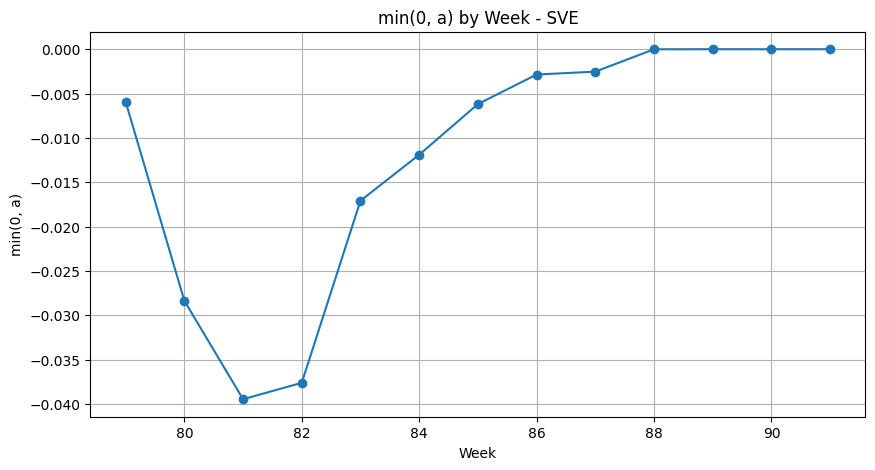

In [ ]:
min_slopes=plot_cumulative_min_slope(base_test)

In [ ]:
clean_slopes = [float(x) for x in min_slopes]
clean_slopes

[-0.005918608479185107,
 -0.028366506627407514,
 -0.039473241669781965,
 -0.037620858485923406,
 -0.01708468551743747,
 -0.011900705305259092,
 -0.006185506117600376,
 -0.0028535186314573506,
 -0.002527316808401817,
 -4.7651734931477946e-06,
 0.0,
 0.0,
 0.0]

In [ ]:
gini_in_time_test

[0.6126544954618018,
 0.6067358869826169,
 0.5559214822069867,
 0.49801515815440545,
 0.47891056744629057,
 0.5813381533720519,
 0.5441833732733259,
 0.5749451571590796,
 0.578733069020013,
 0.5507613672739058,
 0.5998157645568287,
 0.5982577206903765,
 0.5481535820277008,
 0.6022051666756374]

In [ ]:
print(stability_results['stability_score'].tolist())

[0.08885764505391985, -1.9097729819960572, -2.9121469643311375, -2.7664388307918477, -0.9688939535487602, -0.5138912280453102, -0.009110961485598774, 0.28674274283037976, 0.31569295342746534, 0.541189610672299, 0.5450092928859109, 0.544254869870103, 0.5472901867167136]


In [ ]:
test_residuals

array([ 0.05611778,  0.04867041, -0.00367275, -0.06310783, -0.08374118,
        0.01715765, -0.02152589,  0.00770714,  0.0099663 , -0.01953416,
        0.02799148,  0.02490468, -0.02672822,  0.02579461])